# PrimBHoles toolkit: 

## Index
    * Set up (load common libraries, paths, etc)
    * Powerspectrum class (side class)
    * Threshold class (side class)
    * PrimBHoles :
        * Abundances Class
        * Merger rates
        * Merger SGWB (TODO)
        * second order SGWB
        * ....
        
        

## Set up

In [1]:
import numpy as np
import scipy.constants as const
import scipy.special as special
from scipy.special import erfc
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from scipy.integrate import dblquad
import scipy.optimize as opt
import matplotlib.pyplot as plt

import matplotlib as mpl


import sys, os
#ROOTPATH = os.path.abspath(os.path.join(os.path.dirname( __file__ ), '..'))
ROOTPATH = os.getcwd()
SOURCEPATH = os.path.abspath(os.path.join(ROOTPATH, 'dev'))
PARAMSPATH = os.path.abspath(os.path.join(ROOTPATH, 'params'))
PLOTSPATH = os.path.abspath(os.path.join(ROOTPATH, 'plots'))
sys.path.append(ROOTPATH)
sys.path.append(SOURCEPATH)
sys.path.append(PARAMSPATH)

from power_spectrum import PowerSpectrum
from params.user_params import physics_units, cosmo_params, PSModels_params
from threshold import ClassThresholdsStandard, ClassThresholdsShapePrescription


# from baseclass import CLASSBase
# from power_spectrum import PowerSpectrum
# from threshold import ClassThresholds
# from merger_rates import MergerRates
# from abundances import CLASSabundances
from primbholes import primbholes 



#Specify the plot style
mpl.rcParams.update({'font.size': 10,'font.family':'serif'})
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rc('text', usetex=True)

mpl.rcParams['legend.edgecolor'] = 'inherit'


## PowerSpectrum

Attributes of  PS_Gaussian 
   >>    {'As': 0.003, 'kp': 5000000000.0, 'sigma': 0.3}
   >> min and max of PS:  0.0, 0.002915571749559469 


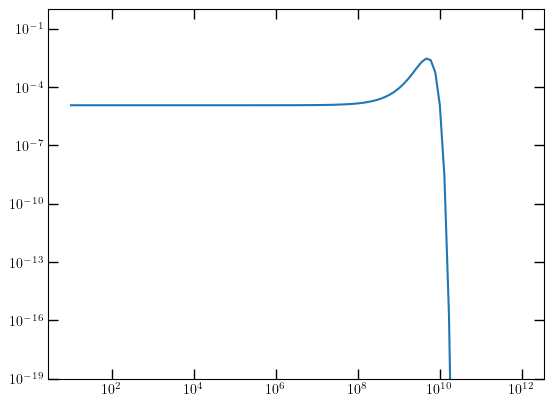

In [2]:
from power_spectrum import PowerSpectrum

# Example one model
myPS = PowerSpectrum.gaussian()

# myPS.As = 0.3
myPS.print_att()

ks = 10**np.linspace(1.0, 12.0, 100, True)   
print(f'   >> min and max of PS:  {np.min(myPS.PS(ks))}, {np.max(myPS.PS(ks))} ' )

plt.plot(ks, myPS.PS(ks))
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-19, 1)
# plt.savefig(PLOTSPATH + "/example_powerspectra_gaussian.png")
plt.show()
# plt.close()


powerlaw
Step 1b: Rescaling of the power spectrum to get f_PBH = 0.1
New scaling :  1e-05


/Users/cjoana/dev/LISA-PBH-WG/dev/abundances.py:133: RuntimeWarning: divide by zero encountered in scalar divide
  beta = np.exp(-0.5*(dcrit[i_s]/sig)**2)/np.sqrt(2*np.pi*(dcrit[i_s]/sig)**2)
/Users/cjoana/dev/LISA-PBH-WG/dev/abundances.py:79: RuntimeWarning: divide by zero encountered in log10
  function =  np.log10(a) -  np.log10(b)


New scaling :  100000.0


/Users/cjoana/dev/LISA-PBH-WG/dev/abundances.py:79: RuntimeWarning: invalid value encountered in log10
  function =  np.log10(a) -  np.log10(b)


New scaling :  1.0
New scaling :  0.0031622776601683794
New scaling :  0.05623413251903491
New scaling :  0.23713737056616552
New scaling :  0.4869675251658631
New scaling :  0.6978305848598664
New scaling :  0.8353625469578262
New scaling :  0.9139816994654905
New scaling :  0.9560239010953075
New scaling :  0.9347664680831878
New scaling :  0.9453354354037362
New scaling :  0.9506646468646612
New scaling :  0.9479962963359845
New scaling :  0.9466649309855664
New scaling :  0.9459999496377831
New scaling :  0.9463323819019411
New scaling :  0.9461661511699938
New scaling :  0.9462492628856798
New scaling :  0.946207706115305
New scaling :  0.9462284842723544
New scaling :  0.9462180951367958
New scaling :  0.946212900611792
New scaling :  0.9462103033599839
New scaling :  0.9462116019849968
New scaling :  0.9462109526722676
New scaling :  0.94621062801607
After rescaling, I get a total abundance of PBHs: fPBH= 0.09999871781687168
Rescaling factor= 0.94621062801607
====
broken_powerla

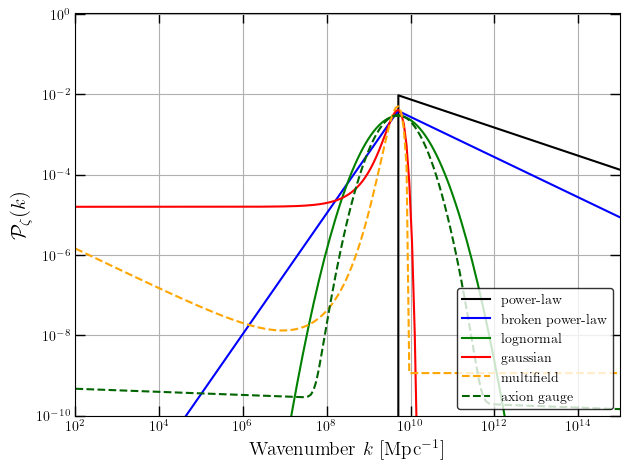

In [3]:
ComputeFPBH = True

# Example with several models
models = [ 
    'powerlaw',
    'broken_powerlaw',
    'lognormal',
    'gaussian',
    'multifield',
    'axion_gauge',
    # 'preheating',
    # 'vacuum'
]

model_name = [
    'power-law',
    'broken power-law',
    'lognormal',
    'gaussian',
    'multifield',
    'axion gauge',
    # 'preheating',   #   (2.20)
    # 'vacuum'
]

color_pal = ['k', 'b', 'g', 'r',  'orange', 'darkgreen', 'purple', 'k']
lstyle = ['-', '-', '-', '-',      '--', '--', '--', '--']


xmin = 10**2
xmax = 10**15
ymin = 1e-10
ymax = 1e0 * 1.05
k_values = 10**np.linspace(np.log10(xmin), np.log10(xmax), 200)

figPk = plt.figure()
figPk.patch.set_facecolor('white')
ax = figPk.add_subplot(111)

scale =1 

for i, model in enumerate(models):
    PM = PowerSpectrum.get_model(model)
    # PM.kp=5e6
    # print('set kp to', PM.kp)
    ps_function = PM.PS
    
    print(model)
    ifpbh = ""
    if ComputeFPBH:
        if model=="vacuum": continue
        pb = primbholes(ps_function=ps_function, fpbh_rescaling=0.1)
        ifpbh = np.round(pb.get_integrated_fPBH(), 2)
        scale = pb.get_spectrum_scaling()
    
    xs = k_values
    ys = PM.PS(kk=k_values)   * scale  
    lbl = f"{model_name[i]}"
    ax.plot(xs, ys, label=lbl, color=color_pal[i], ls=lstyle[i])

ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.xlabel('Wavenumber $k$  [Mpc$^{-1}$]', fontsize=14)
plt.ylabel(r'$\mathcal{P}_{\zeta} (k)$', fontsize=15)

plt.legend(loc=4)
plt.grid(True)
plt.tight_layout()
plt.savefig(PLOTSPATH + "/example_powerspectra_models.png", dpi=300)
plt.show()


After rescaling, I get a total abundance of PBHs: fPBH= 1.0004890912864883
Rescaling factor= 0.317517128631511

====

After rescaling, I get a total abundance of PBHs: fPBH= 0.9998851435809062
Rescaling factor= 2.9369655047216514

====

After rescaling, I get a total abundance of PBHs: fPBH= 0.9996394049047383
Rescaling factor= 0.12092675313074892

====

scaling :  1.567039854036664
After rescaling, I get a total abundance of PBHs: fPBH= 0.9999582853654736
Rescaling factor= 1.567039854036664

====

After rescaling, I get a total abundance of PBHs: fPBH= 0.9997040229497783
Rescaling factor= 0.10525102491756518

====

After rescaling, I get a total abundance of PBHs: fPBH= 1.0000573476724959
Rescaling factor= 0.12104099141699594

powerlaw
broken_powerlaw
lognormal
gaussian
multifield
axion_gauge


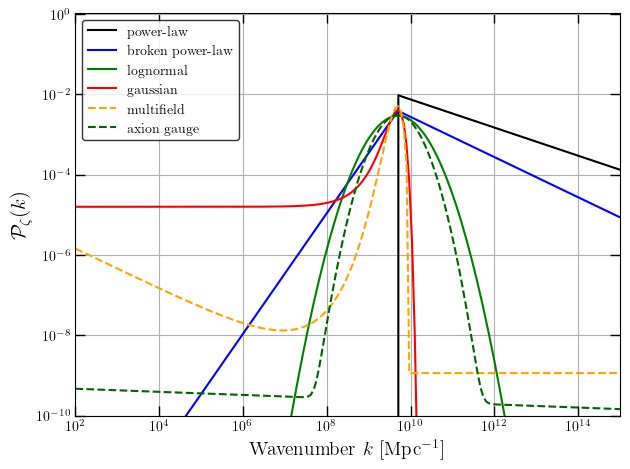

In [8]:
ComputeFPBH = False

# Example with several models
models = [ 
    'powerlaw',
    'broken_powerlaw',
    'lognormal',
    'gaussian',
    'multifield',
    'axion_gauge',
    # 'preheating',
    # 'vacuum'
]

model_name = [
    'power-law',
    'broken power-law',
    'lognormal',
    'gaussian',
    'multifield',
    'axion gauge',
    # 'preheating',   #   (2.20)
    #'vacuum'
]

scales = [
0.94621062801607, 3.862320053155609, 0.14105680262395384,  1.3626696793470874, 0.5739895427438906, 0.15146162777820546    
]

color_pal = ['k', 'b', 'g', 'r',  'orange', 'darkgreen', 'purple', 'k']
lstyle = ['-', '-', '-', '-',      '--', '--', '--', '--']


xmin = 10**2
xmax = 10**15
ymin = 1e-10
ymax = 1e0 * 1.05
k_values = 10**np.linspace(np.log10(xmin), np.log10(xmax), 200)

figPk = plt.figure()
figPk.patch.set_facecolor('white')
ax = figPk.add_subplot(111)

scale =1 

for i, model in enumerate(models):
    PM = PowerSpectrum.get_model(model)
    # PM.kp=5e6
    # print('set kp to', PM.kp)
    ps_function = PM.PS
    
    print(model)
    ifpbh = ""
    if ComputeFPBH:
        if model=="vacuum": continue
        pb = primbholes(ps_function=ps_function, fpbh_rescaling=0.1)
        ifpbh = np.round(pb.get_integrated_fPBH(), 2)
        scale = pb.get_spectrum_scaling()
    
    scale = scales[i]
    
    xs = k_values
    ys = PM.PS(kk=k_values)   * scale  
    lbl = f"{model_name[i]}"
    ax.plot(xs, ys, label=lbl, color=color_pal[i], ls=lstyle[i])

ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.xlabel('Wavenumber $k$  [Mpc$^{-1}$]', fontsize=14)
plt.ylabel(r'$\mathcal{P}_{\zeta} (k)$', fontsize=15)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(PLOTSPATH + "/example_powerspectra_models.png", dpi=300)
plt.show()

## Threshold

In [9]:
from power_spectrum import PowerSpectrum
from params.user_params import physics_units, cosmo_params, PSModels_params
from threshold import ClassThresholdsStandard, ClassThresholdsShapePrescription

###### Set mass example:

Msun = physics_units.m_sun
# mPBH = Msun * 1.0
mPBH = 1.0

###### Set model example: 

PS_model = PowerSpectrum.axion_gauge()    
PS_func =  PS_model.PS_plus_vacuum


### Print threshold 

print(" ")
print("Example using Standard formalism:  ")
deltacrit = ClassThresholdsStandard(PS_func=PS_func)

dc = deltacrit.get_deltacr()
dc_thermal = deltacrit.get_deltacr_with_thermalhistory(mPBH)
print(" >> delta crit without / with thermal history ", dc, dc_thermal)

print("\n")
print("Example using Shape Prescription formalism: ")
deltacrit = ClassThresholdsShapePrescription(ps_function=PS_func)

dc = deltacrit.get_deltacr()
dc_thermal = deltacrit.get_deltacr_with_thermalhistory(mPBH)
print(" >> delta crit without / with thermal history ", dc, dc_thermal)

print("\n")
print("Issue: methods give very diferent threshold values. ")


## TODO: save shape parameter, and funtion to print it

 
Example using Standard formalism:  
 >> delta crit without / with thermal history  0.5 0.4618490480716858


Example using Shape Prescription formalism: 
 >> delta crit without / with thermal history  0.8695025750447951 0.8031578731606364


Issue: methods give very diferent threshold values. 


In [31]:
from threshold import ClassThresholdsStandard, ClassThresholdsShapePrescription

AsPBH, kp, sigma = [0.0205, 2.e6, 1.]       ## This example works fine! 
# AsPBH, kp, sigma = [0.0205, 2.e6, 0.5]    ## This example crashes...          # TODO: method need some testing! 

def PS_func(kk):
        return AsPBH * np.exp(- np.log(kk / kp) ** 2 / (2 * sigma ** 2))


method = ClassThresholdsShapePrescription(ps_function=PS_func)

dc = method.get_deltacr()

print(" >> delta critical is ", dc)

 >> delta critical is  0.8694606172753746


## PrimBHoles 

### Abundances

In [35]:
pb = primbholes()

##Example:
## Model A: Gaussian
sig =  0.25
As = 0.01*sig
kp = 1e6
ps_model = PowerSpectrum.gaussian(As=As, sigma=sig, kp=kp)

## Select with vacuum
ps_func =  ps_model.PS_plus_vacuum        # This is the default to calculate sigma and fPBH

pb.set_powerspectrum(ps_function=ps_func)

pb = primbholes(ps_function=ps_func)
# pb = CLASSabundances(ps_function = ps_func, threshold_method="standard")

mass = 10**np.linspace(-6,8, 30)  #* Msun
fpbh = pb.get_fPBH(mass)

floor = 1e-8
beta = pb.get_beta(mass)  #+ floor
fpbh = pb.get_fPBH(mass)  + floor
sigma = pb.get_variance(mass)

# dc = pb.get_deltacr()  ## TODO: not implemented yet in the primbholes class


print(f"fPBH = {fpbh}")

print(" >> delta critical is ", dc)

fPBH = [1.00000000e-08 1.00000000e-08 1.00000000e-08 1.00000000e-08
 1.00000000e-08 1.00000000e-08 1.00000000e-08 1.00000000e-08
 1.00000000e-08 1.00000000e-08 1.00000000e-08 1.00000000e-08
 1.00000000e-08 1.00000000e-08 1.00000000e-08 2.78570083e-03
 1.00000000e-08 1.00000000e-08 1.00000000e-08 1.00000000e-08
 1.00000000e-08 1.00000000e-08 1.00000000e-08 1.00000000e-08
 1.00000000e-08 1.00000000e-08 1.00000000e-08 1.00000000e-08
 1.00000000e-08 1.00000000e-08]
 >> delta critical is  0.8694606172753746


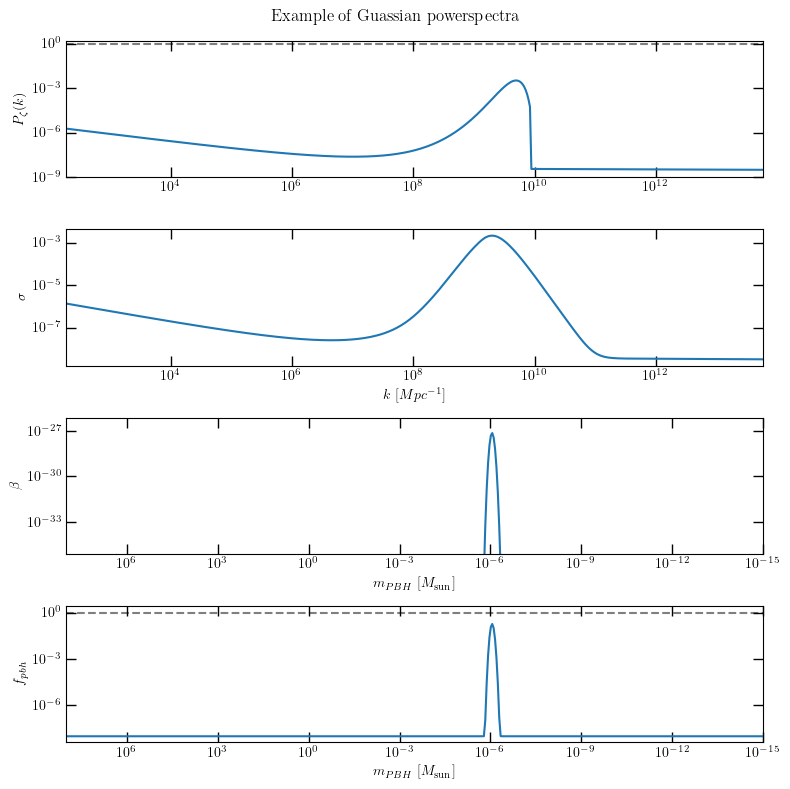

In [4]:
def k_of_m(mass):
    ratio_mPBH_over_mH = 0.8
    kmsun = 2.1e6
    mH = mass / ratio_mPBH_over_mH
    kk = kmsun / mH ** (0.5)  # S. Clesse: to be checked
    return kk
def m_of_k(k):

    ratio_mPBH_over_mH = 0.8
    kmsun = 2.1e6

    mass = (kmsun/k)**2 *  ratio_mPBH_over_mH
    return mass




test = 0
Msun = physics_units.m_sun

## Model A: Gaussian
# sig =  0.3
# As = 0.01*sig
# kp = 5e9
# PS_model = PowerSpectrum.gaussian(As=As, sigma=sig, kp=kp)

## Model B : axion_gauge
# PS_model = PowerSpectrum.axion_gauge()    
# PS_model = PowerSpectrum.axion_gauge(As=As, sigma=sig, kp=kp)

## Model C : multi_field
kf = 5e9             # scale H-crossing at sharp turn  [mpc^-1]
P0 = 2e-9 * 0.5739895427438906    # Amplitude Pk in absence of transient instability
eta = 3.             # TODO: check value
delta = 2.5          # TODO: check value
kp = kf
PS_model = PowerSpectrum.multifield()    
PS_model = PowerSpectrum.multifield(kf=kf, eta=eta, delta=delta)


## Select with vacuum
PS_func =  PS_model.PS_plus_vacuum        # This is the default to calculate sigma and fPBH

## Select threshold calc method
a = primbholes(ps_function = PS_func, threshold_method="standard")    # a = CLASSabundances(ps_function = PS_func, threshold_method="standard")
# a = primbholes(ps_function = PS_func, threshold_method="ShapePrescription")   # a = CLASSabundances(ps_function = PS_func, threshold_method="ShapePrescription")   

## Params range: 
mass = 10**np.linspace(-15,8, 500)  #* Msun
floor = 1e-8

# Compute quantities
beta = a.get_beta(mass)  #+ floor
fpbh = a.get_fPBH(mass)  + floor
sigma = a.get_variance(mass)


##### Make Plot 

fig, axs = plt.subplots(4,1, figsize=(8,8))

fig.suptitle("Example of Guassian powerspectra")
kk =  k_of_m(mass)
ax = axs[0]
ax.plot(kk, PS_func(kk))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$P_\zeta(k)$")
ax.set_ylim(1e-9, 1.5)
ax.axhline(1, color="k", ls="--", alpha=0.5)
ax.set_xlim(min(kk), max(kk))


ax = axs[1]
ax.plot(kk, sigma)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\sigma$")
ax.set_xlabel(r"$k\ [Mpc^{-1}]$")
ax.set_xlim(min(kk), max(kk))

ax = axs[2]
ax.plot(mass, beta)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\beta$")
ax.set_xlabel(r"$m_{PBH}\ [M_{\rm sun}]$")
ax.set_xlim(max(mass), min(mass))
ax.set_ylim(beta.max()*1e-8, beta.max()*10)

ax = axs[3]
ax.plot(mass, fpbh)
ax.axhline(1, color="k", ls="--", alpha=0.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$f_{pbh}$")
ax.set_xlabel(r"$m_{PBH}\ [M_{\rm sun}]$")
ax.set_xlim(max(mass), min(mass))

plt.tight_layout()
# plt.savefig(PLOTSPATH + "/example_abundances.png")
# plt.show()

### Merger rates

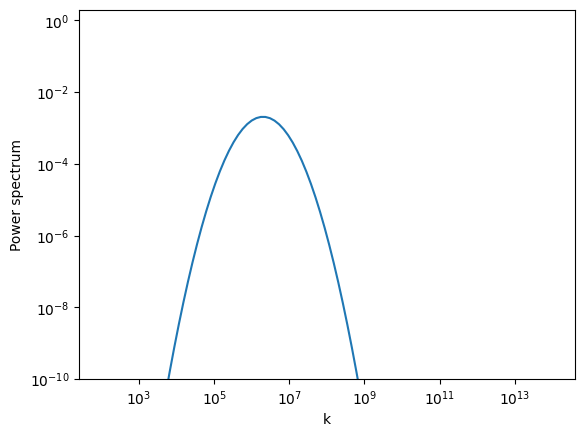

/var/folders/1g/rr9w26j92c7814lfhsctmwh40000gn/T/ipykernel_6019/3799999495.py:36: RuntimeWarning: divide by zero encountered in log10
  Z =  np.transpose(np.log10(sol))


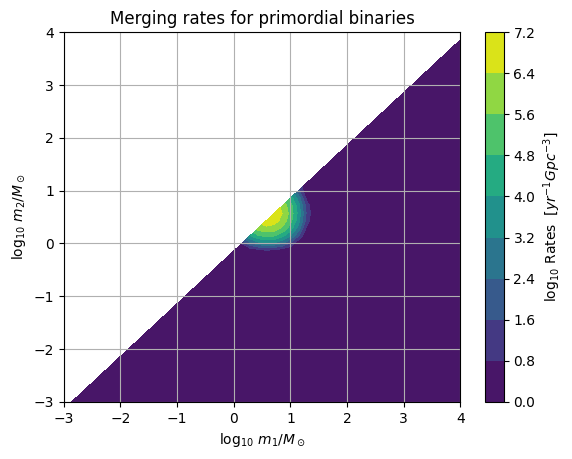

In [51]:
from power_spectrum import PowerSpectrum
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

masses =  10**np.linspace(-3,4, 50)  

# PS_model = PowerSpectrum.gaussian(kp=2.e6, As=0.0205, sigma=1.)
# PS_func =  PS_model.PS

def PS_func(kk):
    AsPBH, kp, sigma = [0.00205, 2.e6, 1.]
    # AsPBH *= 1.183767
    return AsPBH * np.exp(- np.log(kk / kp) ** 2 / (2 * sigma ** 2))


ks = 10**np.linspace(2,14, 100) 
plt.plot(ks , PS_func(ks))
plt.ylim(1e-10, 2)
plt.ylabel("Power spectrum")
plt.xlabel("k")
plt.xscale("log")
plt.yscale("log")
plt.show()

pb =  primbholes(ps_function=PS_func)   #  CLASSabundances(ps_function=PS_func)
fpbhs = pb.get_fPBH(masses)

sol = MergerRates().get_rates_clusters(masses, fpbhs) 
# sol = pb.get_rates_clusters(masses, fpbhs)                       # TODO : currently don't work (problem with class inheritance) 



figRprim = plt.figure()
# figRprim.patch.set_facecolor('white')
ax = figRprim.add_subplot(111)
Z =  np.transpose(np.log10(sol))
floor = 0.0
Z[(Z<floor)] = floor
cs=ax.contourf(np.log10(masses),np.log10(masses),Z, levels=10) 
plt.title("Merging rates for primordial binaries")
cbar = figRprim.colorbar(cs)
cbar.set_label(r'log$_{10}$ Rates  [$yr^{-1}Gpc^{-3}$]', rotation=90)
#ax.set_xscale('log')
#ax.set_yscale('log')
#plt.ylim(1.e-4,1.e1)
plt.xlabel(r'$\log_{10} \, m_1 /M_\odot $')
plt.ylabel(r'$\log_{10} \, m_2 /M_\odot $')
plt.grid(True)
# figRprim.savefig(PLOTSPATH + "/example_RatesPrim.png", facecolor=figRprim.get_facecolor(), edgecolor='none',dpi=300)
plt.show()

### Merger SGWB    (TODO)

In [ ]:
# TODO
##########






### 2nd Order SGWB

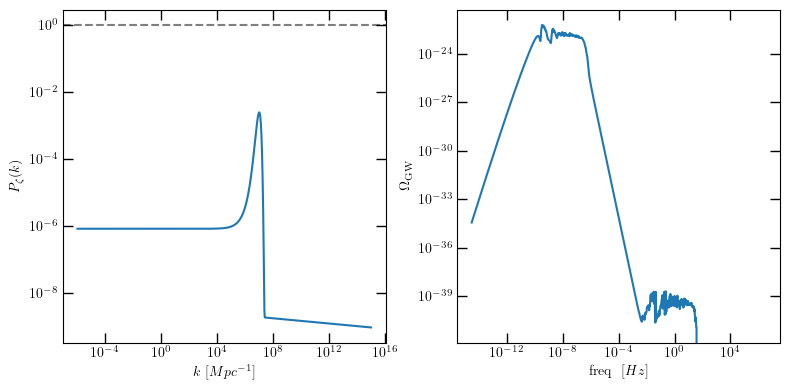

In [7]:
from second_order_SGWB import SecondOrderSGWB

## Model A: Gaussian
sig =  0.25
As = 0.01*sig
kp = 1e7
ps_model = PowerSpectrum.gaussian(As=As, sigma=sig, kp=kp)

## Model B : axion_gauge
# ps_model = PowerSpectrum.axion_gauge()    
# ps_model = PowerSpectrum.axion_gauge(As=As, sigma=sig, kp=kp)

## Select with vacuum
ps_func =  ps_model.PS_plus_vacuum        # This is the default to calculate sigma and fPBH

# Call the class 
SOGW = SecondOrderSGWB(ps_function=ps_func)

kvals = 10**np.linspace(-6,15, 1000)

# Call the class 
SOGW = SecondOrderSGWB(ps_function=ps_func)   
## SOGW = pb.get_2ndOrderGWs(ps_function=PS_func)                 ## TODO: not implemented yet in the primbhole class

kvals = 10**np.linspace(-6,15, 1000)  


fig, axs = plt.subplots(1,2, figsize=(8,4))
###################################################

ax = axs[0]
x = kvals
y = ps_func(kvals)
###################
ax.plot(x, y)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$P_\zeta(k)$")
ax.set_xlabel(r"$k\ [Mpc^{-1}]$")
# ax.set_ylim(1e-9, 1.5)
ax.axhline(1, color="k", ls="--", alpha=0.5)
###################################################

ax = axs[1]
x = SOGW.get_frequencies(kvals)
y = SOGW.get_OmegaGWs(kvals)
###################
ax.plot(x, y)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\Omega_{\rm GW}$")
ax.set_xlabel(r"freq $\ [Hz]$")
# ax.set_ylim(1e-9, 1.5)
# ax.axhline(1, color="k", ls="--", alpha=0.5)

plt.tight_layout()
# plt.savefig(PLOTSPATH + "/example_2ndOrderSGWB.png", dpi=300)

plt.show()

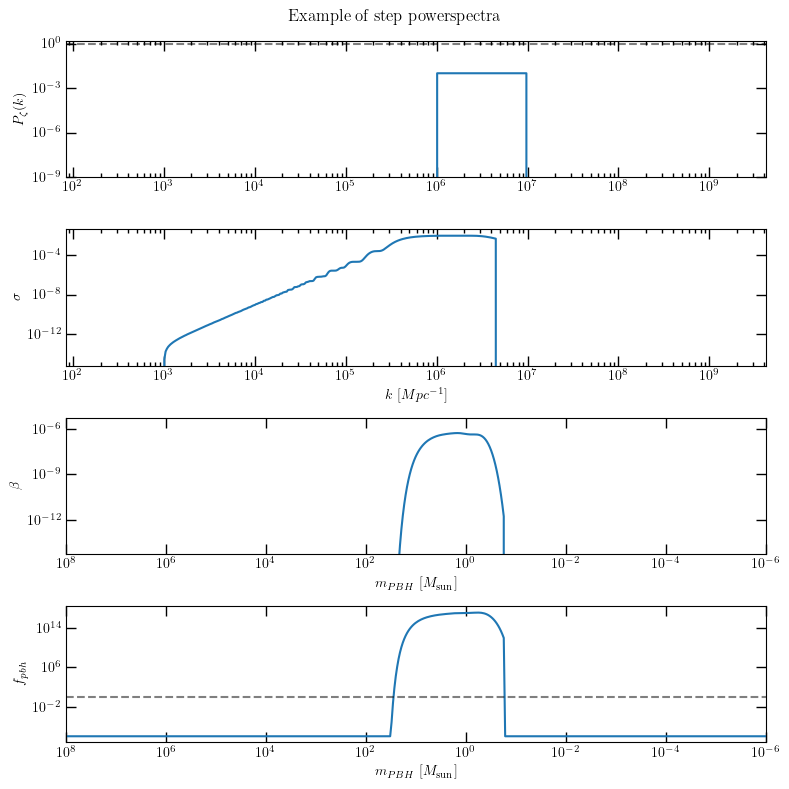

In [24]:
def k_of_m(mass):
    ratio_mPBH_over_mH = 0.8
    kmsun = 2.1e6
    mH = mass / ratio_mPBH_over_mH
    kk = kmsun / mH ** (0.5)  # S. Clesse: to be checked
    return kk
def m_of_k(k):

    ratio_mPBH_over_mH = 0.8
    kmsun = 2.1e6

    mass = (kmsun/k)**2 *  ratio_mPBH_over_mH
    return mass




test = 0
Msun = physics_units.m_sun



# def PS_func(k, ma=1e-2, mb=1e2):
    
#     kk = k 
#     out = np.zeros_like(kk)
#     a = k_of_m(ma)
#     b = k_of_m(mb)
#     mask = ((kk<=a) & (kk>=b))
#     out[mask] = 1
#     mask = ((kk>=a) & (kk<=b))
#     out[mask] = 1
    
#     return out * 0.01


def PS_func(k, a=1e6, b=1e7):
    
    kk = k 
    out = np.zeros_like(kk)
    mask = ((kk<=a) & (kk>=b))
    out[mask] = 1
    mask = ((kk>=a) & (kk<=b))
    out[mask] = 1
    
    return out * 0.01
    
    
    
    
    
## Select threshold calc method
a = primbholes(ps_function = PS_func, threshold_method="standard")    # a = CLASSabundances(ps_function = PS_func, threshold_method="standard")
# a = primbholes(ps_function = PS_func, threshold_method="ShapePrescription")   # a = CLASSabundances(ps_function = PS_func, threshold_method="ShapePrescription")   

## Params range: 
mass = 10**np.linspace(-6,8, 500)  #* Msun
floor = 1e-8

# Compute quantities
beta = a.get_beta(mass)  #+ floor
fpbh = a.get_fPBH(mass)  + floor
sigma = a.get_variance(mass)


##### Make Plot 

fig, axs = plt.subplots(4,1, figsize=(8,8))

fig.suptitle("Example of step powerspectra")
kk =  k_of_m(mass)
ax = axs[0]
ax.plot(kk, PS_func(kk))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$P_\zeta(k)$")
ax.set_ylim(1e-9, 1.5)
ax.axhline(1, color="k", ls="--", alpha=0.5)


ax = axs[1]
ax.plot(kk, sigma)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\sigma$")
ax.set_xlabel(r"$k\ [Mpc^{-1}]$")

ax = axs[2]
ax.plot(mass, beta)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\beta$")
ax.set_xlabel(r"$m_{PBH}\ [M_{\rm sun}]$")
ax.set_xlim(max(mass), min(mass))
ax.set_ylim(beta.max()*1e-8, beta.max()*10)

ax = axs[3]
ax.plot(mass, fpbh)
ax.axhline(1, color="k", ls="--", alpha=0.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$f_{pbh}$")
ax.set_xlabel(r"$m_{PBH}\ [M_{\rm sun}]$")
ax.set_xlim(max(mass), min(mass))

plt.tight_layout()
# plt.savefig(PLOTSPATH + "/example_abundances.png")
plt.show()